https://cedric.cnam.fr/~soutif/QKP/QKP.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
import cvxpy as cp

In [2]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [3]:
with open('jeu_100_50_3.txt', 'r') as f:
    lines = f.read().split('\n')

In [4]:
dim = int(lines[1])
diag = np.array([int(x) for x in lines[2].split()])

In [5]:
off_diag = []

for i in range(3, dim + 3 - 1):
    off_diag.append(np.array([int(x) for x in lines[i].split()]))

In [6]:
constraint_type = int(lines[dim + 3])
# 0 if the constraint is of type <= (i.e. always since we are considering (QKP) instances)
# and 1 if the constraint is an eglity constraint
print(constraint_type) 

0


In [7]:
capacity = int(lines[dim + 3 + 1])
capacity

156

In [8]:
weights = np.array([int(x) for x in lines[dim + 3 + 2].split()])

In [9]:
A = np.zeros((dim, dim))
for i in range(dim):
    A[i, i] = diag[i] / 2
    if i < dim - 1:
        A[i, i+1:] = off_diag[i] / 2
        
A += A.T

In [10]:
A_torch = torch.tensor(A, dtype=torch.float64)
weights_torch = torch.tensor(weights, dtype=torch.float64)

In [11]:
potential = lambda x: -torch.einsum('ni,ij,nj->n', x, A_torch, x)
isvalid = lambda x: (x >= 0).all(axis=-1) * (x <= 1).all(axis=-1) * (x @ weights_torch <= capacity)

In [52]:
num_particles = 10
particles = np.round(np.random.rand(num_particles, dim) / weights)
particles = torch.tensor(particles, dtype=torch.float64, requires_grad=True)

counter = 2

C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [ ]:
best_particle = torch.zeros(dim, dtype=torch.float64)
best_val = 0

num_iters = 5000
# counter = 2

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)
for i in range(num_iters):
    vals = potential(particles)
    vals.sum().backward()
    beta = 10 * np.sin(i / 1000) ** 2 + 1
    with torch.no_grad():
        grad = particles.grad
        
        rounded_particles = torch.round(particles).to(torch.float64)
        rounded_particles = rounded_particles[isvalid(rounded_particles) > 0]
        
        if len(rounded_particles) > 0:
            rounded_vals = potential(rounded_particles)
            rounded_history[i] = rounded_vals.min()
        else:
            rounded_history[i] = best_val
            
        history[i] = vals.min()
    
        # C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        # C = torch.clip(C, -1000, 1000)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = rounded_particles[jj].detach().clone()
            best_val = rounded_history[i].detach().clone()
    
    counter += 1
    particles.grad.zero_()

In [128]:
h = 0.01
beta = 1
C = 1e-5 * torch.eye(dim, dtype=torch.float64)

In [129]:
beta = 1

In [130]:
best_particle = torch.zeros(dim, dtype=torch.float64)
best_val = 0

num_iters = 5000
# counter = 2

history = torch.zeros(num_iters, dtype=torch.float64)
rounded_history = torch.zeros(num_iters, dtype=torch.float64)
for i in range(num_iters):
    vals = regularized_potential(particles)
    vals.sum().backward()
    beta = 10 * np.sin(i / 1000) ** 2 + 1
    with torch.no_grad():
        # C1 = C + 1e-5 * torch.eye(dim, dtype=torch.float64)
        # sqrt_C1 = torch.linalg.cholesky(C1, upper=False)
        
        # particles += -particles.grad @ C1 * h + np.sqrt(2 * h / beta) * torch.randn_like(particles) @ sqrt_C1
        particles += -particles.grad * h + np.sqrt(2 * h / beta) * torch.randn_like(particles)
        
        rounded_particles = torch.round(particles).to(torch.float64)
        rounded_particles = rounded_particles[isvalid(rounded_particles) > 0]
        
        if len(rounded_particles) > 0:
            rounded_vals = potential(rounded_particles)
            rounded_history[i] = rounded_vals.min()
        else:
            rounded_history[i] = best_val
            
        history[i] = vals.min()
    
        # C = (1 - 0.1 / counter) * C + (0.1 / counter) * covariance(particles)
        # C = torch.clip(C, -1000, 1000)
        
        if rounded_history[i] < best_val:
            jj = torch.argmin(rounded_vals)
            best_particle = rounded_particles[jj].detach().clone()
            best_val = rounded_history[i].detach().clone()
    
    counter += 1
    particles.grad.zero_()

In [131]:
best_val

0

In [132]:
history.min()

tensor(nan, dtype=torch.float64)

In [105]:
capacity

156

In [106]:
best_particle @ weights_torch

tensor(152., dtype=torch.float64)

In [107]:
potential(best_particle.reshape(1, -1))

tensor([-918.], dtype=torch.float64)

In [108]:
rounded_history.min()

tensor(-918., dtype=torch.float64)

In [109]:
history.min()

tensor(-7017.5107, dtype=torch.float64)

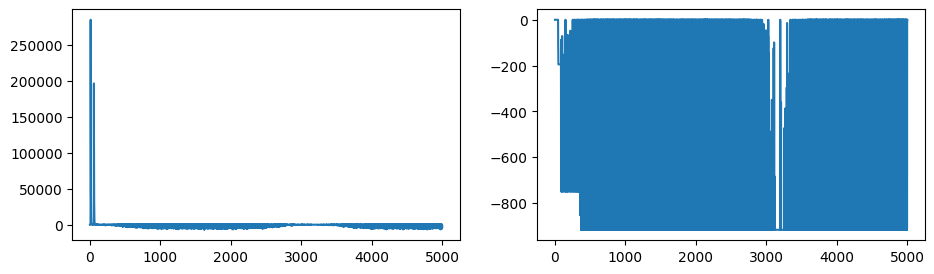

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

axs[0].plot(history)
axs[1].plot(rounded_history)

In [111]:
best_particle

tensor([-0., 0., -0., 0., -0., 1., 0., 1., -0., -0., -0., 0., -0., 1., 0., -0., 0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., 0., 0., -0., -0., -0., 1., -0., -0.,
        -0., 0., 0., -0., 0., 0., -0., -0., 0., -0., -0., 0., -0., -0., -0., 1., -0., -0.,
        0., 0., -0., 1., 0., -0., -0., -0., -0., -0., -0., -0., -0., 0., 0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., 0., -0., -0., 0., -0., -0., -0., -0., 0., -0., -0.,
        -0., 0., -0., 0., 0., 1., -0., -0., 0., -0.], dtype=torch.float64)

In [68]:
potential = lambda x: -torch.einsum('i,ij,j', x, A_torch, x)

In [69]:
num_iters = 10_000

v = np.ones(2 * dim) * 0.01

# particle = torch.tensor(np.ones(dim), dtype=torch.float64, requires_grad=True)
particle = torch.zeros(dim, dtype=torch.float64, requires_grad=True)
D_temp = torch.ones(dim, dtype=torch.float64)
C = torch.diag(D_temp)
sqrt_C = torch.diag(D_temp)
counter = 1
alpha = 0.1
h = 0.1
w = np.ones(2 * dim)

In [72]:
# D_temp = torch.ones(dim, dtype=torch.float64)
best_val = np.inf
best_particle = None
num_invalid_moves = 0

history = torch.zeros(num_iters, dim)
history_val = torch.zeros(num_iters)
for i in range(num_iters):
    val = potential(particle)
    history_val[i] = val
    
    if val < best_val:
        best_val = val
        best_particle = particle.detach().clone()
    
    val.backward()
    
    a = 1 * np.cos(np.pi * i / 1000) ** 2 + 0.01
    d = -C @ particle.grad + np.sqrt(2) * sqrt_C @ torch.randn_like(particle) * a
    k = torch.argmax(abs(d))
    
    with torch.no_grad():
        current_capacity = weights_torch @ particle
        
        particle[k] += 1 if d[k] > 0 else -1
        
        D_temp = (1 - alpha) * D_temp + alpha * particle.grad ** 2

        C = torch.diag(1 / torch.sqrt(D_temp))
        # sqrt_C = torch.sqrt(C)
        # v = torch.concatenate([D_temp, D_temp]).detach().numpy()

        if not isvalid(particle):
            num_invalid_moves += 1
            particle[k] += -1 if d[k] > 0 else 1
        history[i] = particle
            
    counter += 1
    
    if i % 1000 == 0:
        print(f"Iteration {i}: {best_val.detach().numpy()}")
    
    particle.grad.zero_()
print(f"Iteration {i}: {best_val.detach().numpy()}")
history = history.numpy()
history_val = history_val.detach().numpy()

Iteration 0: -997.0
Iteration 1000: -997.0
Iteration 2000: -997.0
Iteration 3000: -997.0
Iteration 4000: -997.0
Iteration 5000: -1329.0
Iteration 6000: -1329.0
Iteration 7000: -1329.0
Iteration 8000: -1329.0
Iteration 9000: -1329.0
Iteration 9999: -1329.0


In [73]:
num_invalid_moves

9988

In [74]:
weights_torch @ best_particle

tensor(154., dtype=torch.float64)

In [75]:
capacity

156

In [76]:
# 18558.00

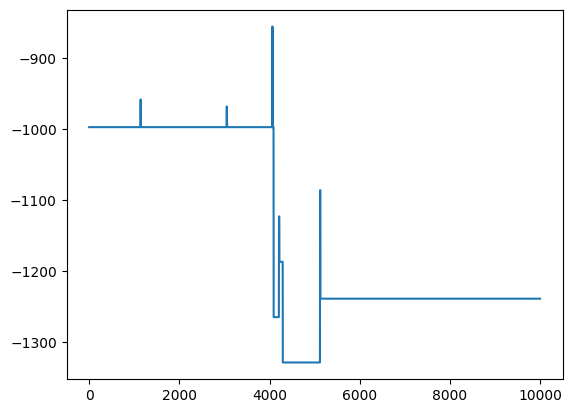

In [77]:
plt.plot(history_val)

In [78]:
potential = lambda x: -x @ A_torch @ x
is_valid = lambda x: (weights_torch @ x <= capacity) and (x >= 0).all() and (x <= 1).all()

In [79]:
num_iters = 10_000

v = np.ones(2 * dim) * 0.01

# particle = torch.tensor(np.ones(dim), dtype=torch.float64, requires_grad=True)
particle = torch.zeros(dim, dtype=torch.float64, requires_grad=True)
D_temp = torch.ones(dim, dtype=torch.float64)
C = torch.diag(D_temp)
sqrt_C = torch.diag(D_temp)
counter = 1
alpha = 0.1
h = 0.1
w = np.ones(2 * dim)

In [80]:
v = np.ones(2 * dim)

In [81]:
# D_temp = torch.ones(dim, dtype=torch.float64)
best_val = np.inf
best_particle = None
num_invalid_moves = 0

history = torch.zeros(num_iters, dim)
history_val = torch.zeros(num_iters)
for i in range(num_iters):
    val = potential(particle)
    history_val[i] = val
    
    if val < best_val:
        best_val = val
        best_particle = particle.detach().clone()
    
    val.backward()
    
    d = -C @ particle.grad
    # d = -particle.grad
    
    with torch.no_grad():
        w = v.copy()
        for k in range(dim):
            if d[k] > 0:
                w[dim + k] += d[k]
            else:
                w[k] += abs(d[k])
        
        current_capacity = weights_torch @ particle
        for jj in range(dim):
            if particle[jj] < 1: 
                w[jj] = 0  # Cannot subtract
                
                # Can only add if the addition is under capacity
                if current_capacity + weights_torch[jj] > capacity:
                    w[jj + dim] = 0
            else:
                # Cannot add
                w[jj + dim] = 0
        
        k = np.random.choice(range(2 * dim), p=w / w.sum())
    
    with torch.no_grad():
        particle[k % dim] += -1 if k < dim else 1
        history[i] = particle
        D_temp = (1 - alpha) * D_temp + alpha * particle.grad ** 2
        
        C = torch.diag(1 / torch.sqrt(D_temp))
        v = 1 / torch.concatenate([D_temp, D_temp]).detach().numpy()
        
        if not is_valid(particle):
            num_invalid_moves += 1
            particle[k % dim] += -1 if k < dim else 1
            
    counter += 1
    
    if i % 1000 == 0:
        print(f"Iteration {i}: {best_val.detach().numpy()}")
    
    particle.grad.zero_()
print(f"Iteration {i}: {best_val.detach().numpy()}")
history = history.numpy()
history_val = history_val.detach().numpy()

Iteration 0: 0.0
Iteration 1000: -557.0
Iteration 2000: -557.0
Iteration 3000: -557.0
Iteration 4000: -557.0
Iteration 5000: -557.0
Iteration 6000: -557.0


/var/folders/99/5f_qszrn5y132sfcdd12k2f80000gn/T/ipykernel_67966/109736038.py:49: RuntimeWarning: overflow encountered in divide
  v = 1 / torch.concatenate([D_temp, D_temp]).detach().numpy()
/var/folders/99/5f_qszrn5y132sfcdd12k2f80000gn/T/ipykernel_67966/109736038.py:41: RuntimeWarning: invalid value encountered in divide
  k = np.random.choice(range(2 * dim), p=w / w.sum())


ValueError: probabilities contain NaN

In [ ]:
w

In [ ]:
num_invalid_moves

In [ ]:
plt.plot(history_val)